In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [13]:
data_covid = pd.read_csv('covid_19_clean_complete.csv')
data_covid["Date"] = pd.to_datetime(data_covid["Date"],infer_datetime_format = True)
data_covid.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


In [38]:
GT_data_covid = data_covid[(data_covid["Country/Region"]=="Guatemala" ) & (data_covid["Confirmed"] > 0)]
GT_data_covid = GT_data_covid[['Date','Confirmed']].copy()
GT_data_covid.head()

,Date,Confirmed
13851,2020-03-14,1
14115,2020-03-15,1
14379,2020-03-16,2
14643,2020-03-17,6
14907,2020-03-18,6


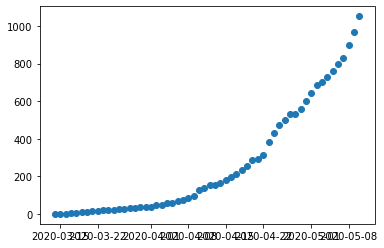

In [39]:
plt.scatter(x=GT_data_covid["Date"], y=GT_data_covid["Confirmed"])

In [40]:
GT_data_covid["log_confirmed"] = np.log(GT_data_covid["Confirmed"])
GT_data_covid.head()

,Date,Confirmed,log_confirmed
13851,2020-03-14,1,0.000000
14115,2020-03-15,1,0.000000
14379,2020-03-16,2,0.693147
14643,2020-03-17,6,1.791759
14907,2020-03-18,6,1.791759


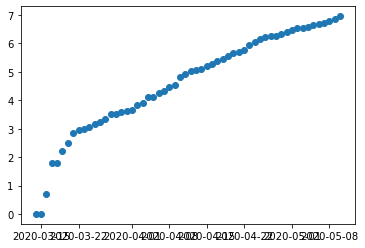

In [41]:
plt.scatter(x=GT_data_covid["Date"], y=GT_data_covid["log_confirmed"])